In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import product, cycle
from IPython.display import Image, HTML
from matplotlib import rcParams
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from scipy.interpolate import interp1d

# Updated Plotly Imports
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyoff

# Ensure Plotly works in Jupyter Notebook
pio.renderers.default = "notebook"

# Suppress warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

The goal of this project is to develop a predictive model based on the order and online customer behavior data to forecast product category a customer is likely to order.

To make the customer purchase prediction model, this project included the following sections :
1.	Exploration and Understanding of the Data Sets<br/>
    1.1	Product Analysis<br/>
        1.1.1	Popularity of prodast1 in terms of the number of orders.<br/>
        1.1.2	Popularity of prodast1 in terms of the number of browsing sessions.<br/>
        1.1.3	The revenue of each type of prodcast1<br/>
    1.2	Customer Behavior<br/>
        1.2.1	Which channel is more popular in terms of event1 and event2<br/>
        1.2.2	Customer Purchase RFM (Recency, Frequency, Monetary value)  Analysis  <br/>
        1.2.3	Customer Segment with RMF <br/>
2.	Model Design and Sampling <br/>
    2.1	Training/ Testing Data Split <br/>
    2.2	 Label Generation <br/>
3.	Feature engineering & Selection <br/>
    3.1	Non-Transaction Data Features <br/>
        3.1.1	How the customer interacts with your website (online event1 and online event2 )<br/>
        3.1.2	How many times a customer browsing an item (No. of sessions) <br/>
    3.2	Transaction Data Features<br/>
        3.2.1	Total Number of orders <br/>
        3.2.2	Order Recency <br/>
        3.2.3	Order Frequency of each category of procat1 <br/>
        3.2.4	Total order revenue<br/>
    3.3	Feature Correlation Matrix <br/>
4.	Model Generation  <br/>
    4.1	Grid Search to find the best parameters <br/>
    4.2	Random Forest Classification Model<br/>
    4.3	 Feature Importance Analysis <br/>
    4.4	Prediction Analysis <br/>
5.	Model Evaluation <br/>
    5.1	Confusion Matrix <br/>
    5.2	 AUC<br/>
6.	Summary & Discussion <br/>


# 1. Exploration and Understanding of the Data Sets

In [3]:
online = pd.read_csv('/content/drive/MyDrive/MDS/online.csv') # Load the Non-transicational dataset
order = pd.read_csv('/content/drive/MyDrive/MDS/order.csv') # Load the Transicational dataset

print(online.info()) # print the info of the Non-transicational dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954774 entries, 0 to 954773
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   session   954774 non-null  int64  
 1   visitor   954774 non-null  int64  
 2   dt        954774 non-null  object 
 3   custno    954774 non-null  int64  
 4   category  954774 non-null  int64  
 5   event1    164928 non-null  float64
 6   event2    954774 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 51.0+ MB
None


In [4]:
print(order.info()) # print the info of the Transicational dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263278 entries, 0 to 263277
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   custno     263278 non-null  int64  
 1   ordno      263278 non-null  int64  
 2   orderdate  263278 non-null  object 
 3   prodcat2   261455 non-null  float64
 4   prodcat1   263278 non-null  int64  
 5   revenue    263278 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 12.1+ MB
None


In [5]:
import pandas as pd

# Function to get unique values and their frequency
def get_unique_values_and_frequency(df):
    unique_values_dict = {}
    frequency_dict = {}

    for col in ['event1','event2']:
        unique_values_dict[col] = df[col].dropna().unique().tolist()
        frequency_dict[col] = df[col].value_counts().to_dict()

    return unique_values_dict, frequency_dict

# Process both datasets
unique_values_online, frequency_online = get_unique_values_and_frequency(online)
# unique_values_order, frequency_order = get_unique_values_and_frequency(order)




In [6]:
unique_values_online

{'event1': [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0],
 'event2': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [7]:
frequency_online

{'event1': {1.0: 51567,
  4.0: 23858,
  2.0: 23312,
  11.0: 20586,
  6.0: 16537,
  7.0: 11416,
  8.0: 10966,
  9.0: 3990,
  5.0: 1473,
  10.0: 1223},
 'event2': {7: 367857,
  3: 129795,
  8: 122402,
  4: 94230,
  1: 86496,
  9: 52145,
  5: 48282,
  6: 29913,
  2: 15419,
  10: 8235}}

In [8]:
print(online.sample(5))


        session  visitor                   dt  custno  category  event1  \
648659  1712353   236550  2017-10-04 12:39:52   27136         3     NaN   
154497  1953984   134030  2017-06-07 13:26:13   13300         2     NaN   
381677  1697528   253190  2017-08-12 12:12:24   54726         3     NaN   
244913  2705146   204017  2017-11-25 14:27:05   16442         3     NaN   
748162   787909   101170  2017-04-09 07:51:28   52745         3     NaN   

        event2  
648659       8  
154497       7  
381677       4  
244913       3  
748162       9  


In [9]:
print(order.sample(10))

        custno  ordno            orderdate  prodcat2  prodcat1  revenue
22710    16482  24612  2017-01-03 19:20:09       3.0         2   136.09
232687   23456  37090  2017-07-20 14:07:53      93.0         1    53.08
215777   39136  68926  2016-03-23 17:43:59      78.0         4    67.51
138719    4999  23901  2019-01-02 18:12:42      16.0         4    15.34
87833    42817  76392  2017-06-21 12:57:08       9.0         3    83.72
6658      4079  72249  2016-12-24 05:15:31       2.0         2   146.04
54839    13677  26245  2016-02-23 13:38:51       4.0         2   142.39
232716    3246   3803  2017-02-22 09:00:56      93.0         1   129.01
38430    13512  36319  2018-09-30 17:28:15       3.0         2    43.24
58148    20132  31044  2016-08-13 15:16:06       4.0         2   113.13


In [10]:
print(f' The most recent time of online session : {online.dt.max()}')
print (f' The start time of online session : {online.dt.min()}')




 The most recent time of online session : 2017-12-31 23:58:05
 The start time of online session : 2016-01-01 00:00:08


In [11]:
print(f' The most recent time of online order : {order.orderdate.max()}')
print(f' The start time of online order : {order.orderdate.min()}')

 The most recent time of online order : 2019-01-02 23:54:58
 The start time of online order : 2016-01-01 05:05:14


### Dataset Descriptions
The data includes two time-series datasets, one is Non-Transactional Data (Online data), another is Transactional Data (Order Data). The Non-Transactional Data (Online data) starts from 2016-01-01 to 2017-12-31, while the Transaction Data starts from 2016-01-01 to 2019-01-02. Therefore, I will only use the data range from 2016-01-01 to 2017-12-31 for both datasets.

### Data Prepreprocessing

- Convert the data type of dt and orderdate to datetime
- Truncate order data only between 2016-01-01 to 2017-12-31

In [12]:
# Convert the data type of dt and orderdate
order['orderdate']= pd.to_datetime(order['orderdate'])
online['dt'] = pd.to_datetime(online['dt'])



# Truncate order data only between 2016-01-01 to 2017-12-31
order = order [order['orderdate'] < '2018-01-01']

## 1.1 Product Analysis

### 1.1.1. Popularity of prodast1 in terms of the number of orders.

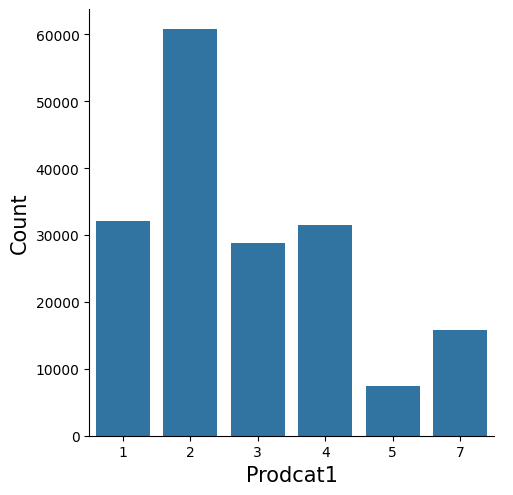

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the count data
count_data = order["prodcat1"].value_counts().reset_index()
count_data.columns = ["Prodcat1", "Count"]

# Save to CSV
count_data.to_csv("/content/drive/MyDrive/MDS/category_counts.csv", index=False)

# Plot the catplot
ax = sns.catplot(x="prodcat1", kind="count", height=5, data=order)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), fontsize=10)

plt.xlabel('Prodcat1', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()


The poplarity is not evenly distributed acrross the categories. The most popular category is 2 in Procat1 and the least popular category is 5 in Procat1 in terms of number of orders.

### 1.1.2. Popularity of prodcat1 in terms of the number of browsing sessions

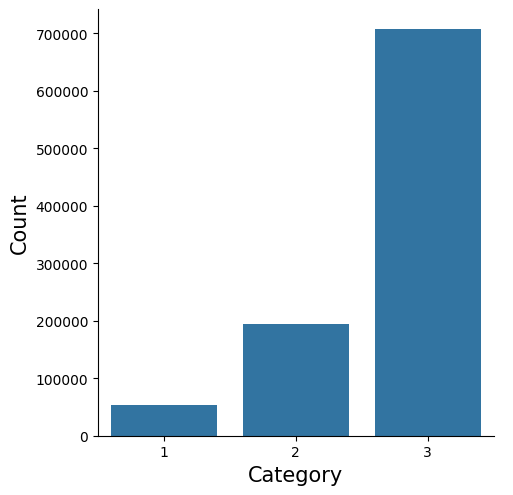

In [14]:


# Create the count data
count_data = online["category"].value_counts().reset_index()
count_data.columns = ["Category", "Count"]

ax = sns.catplot(x="category", kind="count", height=5, data=online)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), fontsize=10)

plt.xlabel('Category', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()


There are only 3 categories in online browsing category (procat1), while procat1 has a total of 6 classes, therefore the online data is incomplete. Among these three categories, the category 3 is the most popular in terms of the number of browsing sessions.

###  1.1.3. Check the Revenue of each category in prodcat1

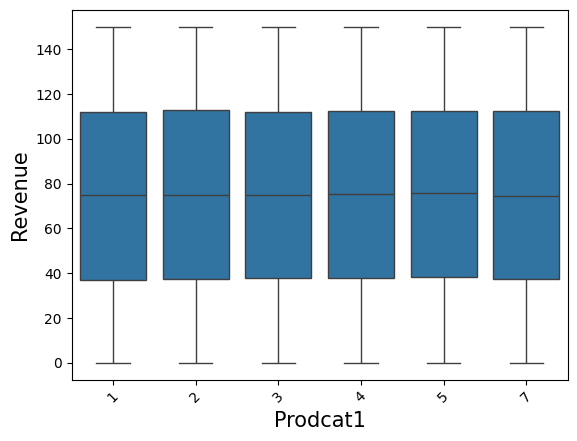

In [15]:


# Compute summary statistics
summary_stats = order.groupby("prodcat1")["revenue"].describe()

# Save to CSV
summary_stats.to_csv("/content/drive/MyDrive/MDS/revenue.csv")

# Plot the boxplot
ax = sns.boxplot(x="prodcat1", y="revenue", data=order)

plt.xlabel("Prodcat1", fontsize=15)
plt.ylabel("Revenue", fontsize=15)
plt.xticks(rotation=45)  # Rotate labels if needed for readability
plt.show()


The revenue is evenly distributed across all categories in procat1. The mean value of all classes is around 75.

## 1.2 Customer Behavior

### 1.2.1 Which channel is more popular in terms of event1 and event2?

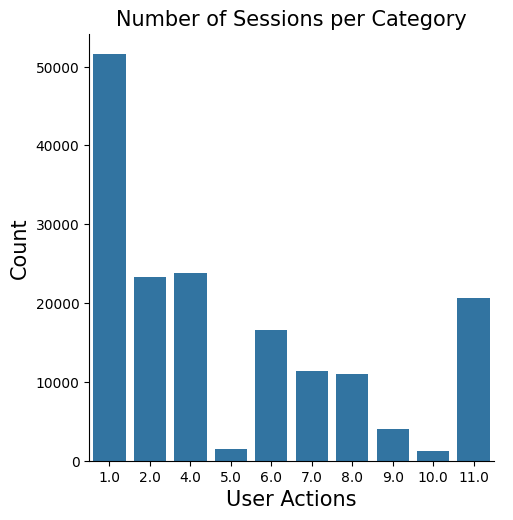

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute count data
count_data = online["event1"].value_counts().reset_index()
count_data.columns = ["Event1", "Count"]

# Save to CSV
count_data.to_csv("/content/drive/MyDrive/MDS/event_session.csv", index=False)

# Plot the catplot
ax = sns.catplot(x="event1", kind="count", height=5, data=online)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), fontsize=10)

plt.xlabel("User Actions", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Number of Sessions per Category", fontsize=15)
plt.show()


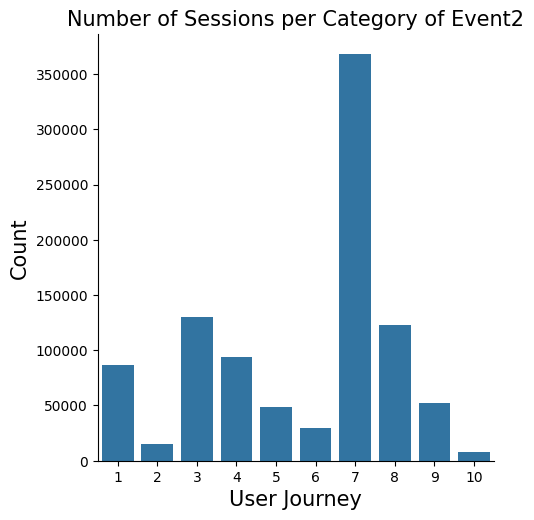

In [17]:
# Compute count data
count_data = online["event2"].value_counts().reset_index()
count_data.columns = ["Event2", "Count"]

# Save to CSV
count_data.to_csv("/content/drive/MyDrive/MDS/User_journey.csv", index=False)

# Plot the catplot
ax = sns.catplot(x="event2", kind="count", height=5, data=online)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), fontsize=10)

plt.xlabel("User Journey", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Number of Sessions per Category of Event2", fontsize=15)
plt.show()

The traffic is not evenly distributed in both events. In event1, class 1 attracts more traffic. In event 2, class 7 attracts more traffic. The channel may affect the purchasing behavior.

## 1.2.2	Customer Purchase RFM (Recency, Frequency, Monetary value)  Analysis  

RMF stands for Recency, Frequency and Monetary value and the RMF metrics are calculated for each customer.  
- Regency: Who have purchased recently? The number of days since last purchased.
- Frequency: who has purchased frequently? It means the total number of purchases.
- Monetary Value: who have high purchase amount? It means the total money customer spend.
<br>

The following steps are used to run the RMF Analysis :
- Calculate the RMF metrics for each customer.
- Add segment numbers to RMF table based on the quantile values.
- Sort according to the RMF scores from the best customers.
- Label the customer for different segments based on their RFM scores.

In [18]:
# Get the max purchase date for each customer
user_segment = order.groupby('custno').orderdate.max().reset_index()


# Calculate the number of inactive numbers of each customer
user_segment['Recency'] = (user_segment['orderdate'].max() - user_segment['orderdate']).dt.days


# Calculate the Frequency and revenue for each customer
rfmTable = order.groupby('custno').agg({'ordno': lambda x: len(x),
                                        'revenue': lambda x: x.sum()}).reset_index().rename(
                                        columns={"ordno": "Frequency", "revenue": "Revenue"})

rfmTable = pd.merge(rfmTable, user_segment, on = 'custno').drop(['orderdate'], axis = 1)

# Functions for RMF score
def RScore(x,p,d):
    """ Generate the Regency Score based on the quantile values"""
    if x<=d[p][0.25] :
        return 1
    elif x<=d[p][0.5]:
        return 2
    elif x<=d[p][0.75]:
        return 3
    else :
        return 4
def FMScore(x,p,d):
    """ Generate the Frequency and Monetary Score based on the quantile values """
    if x<=d[p][0.25] :
        return 4
    elif x<=d[p][0.5]:
        return 4
    elif x<=d[p][0.75]:
        return 2
    else :
        return 1

# Add segment numbers to RMF table based on the quantile values.
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
rfmTable['r_quartile'] = rfmTable['Recency'].apply(RScore, args=('Recency',quantiles,))
rfmTable['f_quartile'] = rfmTable['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfmTable['m_quartile'] = rfmTable['Revenue'].apply(FMScore, args=('Revenue',quantiles,))


# Calculate the RFM score of each customer
rfmTable['RFMScore'] = rfmTable.r_quartile.map(str) + \
                           rfmTable.f_quartile.map(str) +\
                           rfmTable.m_quartile.map(str)
# Sort according to the RMF scores from the best customers
rfmTable = rfmTable.sort_values(by = ['RFMScore'])

Text(0.5, 1.0, 'Distribution of Recency')

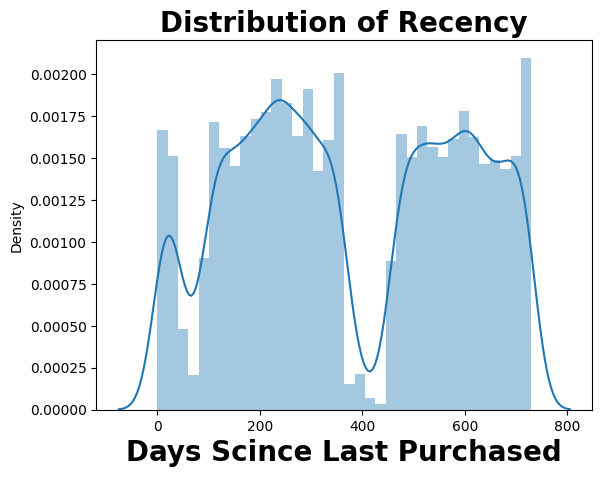

In [19]:
ax = sns.distplot(rfmTable.Recency)
plt.xlabel('Days Scince Last Purchased', fontsize = 20, weight = 'bold')
plt.title('Distribution of Recency',
          fontsize = 20, weight = 'bold')

In [20]:
rfmTable[['Frequency', 'Revenue', 'Recency']].describe()

,Frequency,Revenue,Recency
count,48819.000000,48819.000000,48819.000000
mean,3.610766,270.937096,376.625023
std,9.303500,701.181259,215.606670
min,1.000000,0.010000,0.000000
25%,1.000000,75.940000,196.000000
50%,2.000000,134.320000,341.000000
75%,3.000000,232.350000,576.000000
max,357.000000,24937.040000,730.000000


From the distribution of frequency, revenue and recency, we can infer that most of customers are inactive and purchase little. There are two peaks in the recency distribution data.

## 1.2.3	Customer Segment with RMF

Generally, the lowest recency, highest frequency and monetary amounts are our best customers. The following dataframe shows the details and markering strategies for each customer segement.

In [21]:
import pandas as pd

rmf = {
    'Segement': ['Best Customers', 'Loyal Customers', 'Big Spenders',
                 'Almost Lost', 'Lost Customers', 'Lost Cheap Customer'],
    'RMF': ['111', 'X1X', 'XX1', '311', '411', '444'],  # Ensuring all values are strings
    'Description': [
        'Bought most recently and most often, and spend the most',
        'Buy most frequently', 'Spend the most',
        "Haven't purchased for some time, but purchased frequently and spent the most",
        "Haven't purchased for a long time, but purchased frequently and spent the most",
        'Last purchased long ago, purchased few, and spent little'
    ],
    'Marketing': [
        'No Price incentives, new products, and loyalty programs',
        'Use R and M to further segment',
        'Market your most expensive products',
        'Aggressive price incentives',
        'Aggressive price incentives',
        "Don't spend too much trying to re-acquire"
    ]
}

# Fixing max_colwidth issue
pd.set_option('display.max_colwidth', None)

# Creating DataFrame
df = pd.DataFrame.from_dict(rmf)
print(df)


              Segement  RMF  \
0       Best Customers  111   
1      Loyal Customers  X1X   
2         Big Spenders  XX1   
3          Almost Lost  311   
4       Lost Customers  411   
5  Lost Cheap Customer  444   

                                                                      Description  \
0                         Bought most recently and most often, and spend the most   
1                                                             Buy most frequently   
2                                                                  Spend the most   
3    Haven't purchased for some time, but purchased frequently and spent the most   
4  Haven't purchased for a long time, but purchased frequently and spent the most   
5                        Last purchased long ago, purchased few, and spent little   

                                                 Marketing  
0  No Price incentives, new products, and loyalty programs  
1                           Use R and M to further segment  
2  

Text(30.176337448559664, 0.5, 'Count')

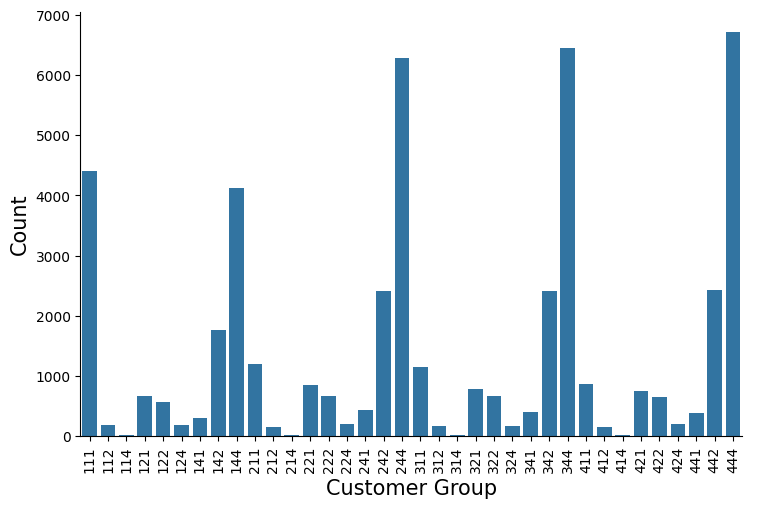

In [22]:
ax = sns.catplot(x="RFMScore", kind="count", data = rfmTable, aspect=15/10)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), fontsize= 10,  rotation='vertical')
plt.xlabel('Customer Group', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

From the customer segmentation distribution, we can infer the following things
- Around 4500 best customers(111) out of  48819 customers.
- Most of customers spend little (large number in group 144,244,344 and 444).
- Very few people buy frequently (less number in group x1X).
<br>

For a better visualization effect, I will only choose 3 customer segments (Best customers (111), Almost Lost (311) and Lost Cheap customers (444)) to see how they differ in the regency, revenue, and frequency.

# 2. Model Design and Sampling

## 2.1 Training/Tesing Data Split

Since the datasets are time-related, it's inappriopriate to  split the training and testing set randomly. Therefore, I will create two time windows for spliting Traing/Testing set. Most of recency is around 1 year based on the eda result, I will use one year data for training features, later half year for labeling data.
- Training Features : 2016-01-01 to 2016-12-31
- Training Labels : 2017-01-01 to 2017-06-30
- Testing Features : 2016-06-30 to 2017-06-30
- Testing Labels : 2017-07-01 to 2017-12-31

In [26]:
import pandas as pd
import datetime as dt

# Ensure orderdate and dt columns are in datetime format
order['orderdate'] = pd.to_datetime(order['orderdate'])
online['dt'] = pd.to_datetime(online['dt'])

## Select the data for Training Features
train_x_order = order[order.orderdate < '2017-01-01']
train_x_online = online[online.dt < '2017-01-01']

## Select the data for Training Labels
train_y = order[(order['orderdate'] > pd.Timestamp("2016-12-31")) &
                (order['orderdate'] < pd.Timestamp("2017-07-01"))]

## Select the data for Testing Features
test_x_order = order[(order['orderdate'] >= pd.Timestamp("2016-06-30")) &
                     (order['orderdate'] < pd.Timestamp("2017-07-01"))]

test_x_online = online[(online['dt'] >= pd.Timestamp("2016-06-30")) &
                        (online['dt'] < pd.Timestamp("2017-07-01"))]

## Select the data for Testing Labels
test_y = order[(order['orderdate'] >= pd.Timestamp("2017-07-01")) &
               (order['orderdate'] < pd.Timestamp("2018-01-01"))]


## 2.2 Label Generation

Binary Labels for each category in procast1.
<br>
1 : Purchased during the labeling time frame <br/>
0 : Not Purchased during the labeling time frame.

To generate the binary labels, I need to do the following steps.
- Table1 : Generate the new dataframe with the unique combination of custno and product1
- Table2 : Count the purchasing count by grouping by the training_y data by custno and prodcut1
- Join two tables using custno and prodcat1
- Convert the non-zero purchasing count to 1 and NA value to 1 in the joined table.

In [27]:
# Training Labels
# Generate the new dataframe with the unique combination of custno and product1

unique_user = order.custno.unique()
unique_prodcat = order.prodcat1.unique()
outlist = list(product(unique_user, unique_prodcat))
df1 = pd.DataFrame(data=outlist, columns=['custno','prodcat1'])

# Count the purchasing count by grouping by the training_y data by custno and prodcut1
df2 = train_y.groupby(['custno', 'prodcat1']).ordno.count().reset_index().rename(columns= {'ordno' :'PurchaseCount'})

# Join Two tables using custno and prodcat1
train_label = pd.merge(df1,df2, how = 'left', on=['custno', 'prodcat1'])

# Convert the non-zero purchasing count to 1 and NA value to 1 in the joined table
train_label.PurchaseCount.fillna(0, inplace = True)
train_label.loc[train_label.PurchaseCount >0, 'PurchaseCount'] =1
# Change the format of data shape
train_label = pd.pivot_table(train_label, values='PurchaseCount', index=['custno'],
               columns=['prodcat1']).reset_index()


# Testing Labels
# Count the purchasing count by grouping by the testing_y data by custno and prodcut1
df3 = test_y.groupby(['custno', 'prodcat1']).ordno.count().reset_index().rename(columns= {'ordno' :'PurchaseCount'})

# Join Two tables using custno and prodcat1
test_label = pd.merge(df1,df3, how = 'left', on=['custno', 'prodcat1'])

# Convert the non-zero purchasing count to 1 and NA value to 1 in the joined table
test_label.PurchaseCount.fillna(0, inplace = True)
test_label.loc[test_label.PurchaseCount >0, 'PurchaseCount'] =1

# change the format of data shape
test_label = pd.pivot_table(test_label, values='PurchaseCount', index=['custno'],
               columns=['prodcat1']).reset_index()

# 3. Feature engineering & Selection

Intuition of features generation:
- Time-related
- Money-related
- purchase-related  
- User behavior-related

Non Trascation Data:
- How the customer interacts with your website (online event1 and online event2 )
- How many times a customer broswer an item (No. of sessions)
<br>

Transcation Data:
- Total Number of Orders
- Order Recency
- Order Frequency of each category of prodcat1
- Order Revenue

## 3.1 Non-Transaction Data Features

In [28]:
# Training Features

# Number of sessions for each customers
online_feature_train = train_x_online.groupby('custno').session.count().reset_index().rename(columns = {'session': 'Total_sessions'})

# Number of sessions for the categories in event1 for each customer
event1_brow = train_x_online.groupby(['custno', 'event1']).session.count().reset_index()
event1_brow = pd.pivot_table(event1_brow, values='session', index=['custno'],
               columns=['event1']).reset_index().rename(columns = {1:'event1_cat1',2:'event1_cat2',3:'event1_cat3',
                                                                  4:'event1_cat4',5:'event1_cat5',6:'event1_cat6',
                                                                  7:'event1_cat7',8:'event1_cat8',9:'event1_cat9',
                                                                  10:'event1_cat10',11:'event1_cat11'})
event1_brow = event1_brow.fillna(0) # replace the missing value with 0

# Number of sessions for the categories in event2 for each customer
event2_brow = train_x_online.groupby(['custno', 'event2']).session.count().reset_index()
event2_brow = pd.pivot_table(event2_brow, values='session', index=['custno'],
               columns=['event2']).reset_index().rename(columns = {1:'event2_cat1',2:'event2_cat2',3:'event2_cat3',
                                                                  4:'event2_cat4',5:'event2_cat5',6:'event2_cat6',
                                                                  7:'event2_cat7',8:'event2_cat8',9:'event2_cat9',
                                                                  10:'event2_cat10'})
event2_brow = event2_brow.fillna(0)

# Number of sessions a customer browsering a category(procat1)
cat_brow = train_x_online.groupby(['custno', 'category']).session.count().reset_index()
cat_brow = pd.pivot_table(cat_brow, values='session', index=['custno'],
               columns=['category']).reset_index().rename(columns = {1:'cat1_brow',2:'cat2_brow',3:'cat3_brow'})
cat_brow = cat_brow.fillna(0)

# Join the tables together with the custno
online_feature_train = pd.merge(online_feature_train, event1_brow, on = 'custno')
online_feature_train = pd.merge(online_feature_train, event2_brow, on = 'custno')
online_feature_train = pd.merge(online_feature_train, cat_brow, on = 'custno')


# Number of sessions for each customers
online_feature_test = test_x_online.groupby('custno').session.count().reset_index().rename(columns = {'session': 'Total_sessions'})



# Number of sessions for the categories in event1 for each customer
event1_brow = test_x_online.groupby(['custno', 'event1']).session.count().reset_index()
event1_brow = pd.pivot_table(event1_brow, values='session', index=['custno'],
               columns=['event1']).reset_index().rename(columns = {1:'event1_cat1',2:'event1_cat2',3:'event1_cat3',
                                                                  4:'event1_cat4',5:'event1_cat5',6:'event1_cat6',
                                                                  7:'event1_cat7',8:'event1_cat8',9:'event1_cat9',
                                                                  10:'event1_cat10',11:'event1_cat11'})
event1_brow = event1_brow.fillna(0) # replace the missing value with 0

# Number of sessions for the categories in event2 for each customer
event2_brow = test_x_online.groupby(['custno', 'event2']).session.count().reset_index()
event2_brow = pd.pivot_table(event2_brow, values='session', index=['custno'],
               columns=['event2']).reset_index().rename(columns = {1:'event2_cat1',2:'event2_cat2',3:'event2_cat3',
                                                                  4:'event2_cat4',5:'event2_cat5',6:'event2_cat6',
                                                                  7:'event2_cat7',8:'event2_cat8',9:'event2_cat9',
                                                                  10:'event2_cat10'})
event2_brow = event2_brow.fillna(0)

# Number of sessions a customer browsering a category(procat1)
cat_brow = test_x_online.groupby(['custno', 'category']).session.count().reset_index()
cat_brow = pd.pivot_table(cat_brow, values='session', index=['custno'],
               columns=['category']).reset_index().rename(columns = {1:'cat1_brow',2:'cat2_brow',3:'cat3_brow'})
cat_brow = cat_brow.fillna(0)

# Join the tables together with the custno
online_feature_test = pd.merge(online_feature_test, event1_brow, on = 'custno')
online_feature_test = pd.merge(online_feature_test, event2_brow, on = 'custno')
online_feature_test = pd.merge(online_feature_test, cat_brow, on = 'custno')

## 3.2	Transaction Data Features

In [29]:
# Training Features

# Get the max purchase date for each customer
user_recency = train_x_order.groupby('custno').orderdate.max().reset_index()

# Calculate the number of inactive numbers of each customer in the training phase
user_recency['Recency'] = (user_recency['orderdate'].max() - user_recency['orderdate']).dt.days
user_recency.drop(columns=['orderdate'])

# Calculate the total order revenue and total number of orders of each customer
order_feature_train = train_x_order.groupby('custno').agg({'ordno': lambda x: len(x),
                    'revenue': lambda x: x.sum()}).reset_index().rename(
                     columns={"ordno": "Total_Order", "revenue": "Total_Revenue"})

# Calculate the purchase frequency for each customer
product_freq = train_x_order.groupby(['custno','prodcat1']).size().reset_index().rename(columns= {0 :'Purchase_frequency'})
product_freq = pd.pivot_table(product_freq, values='Purchase_frequency', index=['custno'],
               columns=['prodcat1']).reset_index().rename(columns = {1:'cat1_freq',2:'cat2_freq',3:'cat3_freq',
                                                                     4:'cat4_freq',5:'cat5_freq',7:'cat7_freq'})
product_freq = product_freq.fillna(0)

# Join these tables together with custno
order_feature_train = pd.merge(order_feature_train, user_recency, on = 'custno')
order_feature_train = pd.merge(order_feature_train, product_freq, on = 'custno')

# Rescaling the Order Frequency
order_feature_train['cat1_freq'] = order_feature_train['cat1_freq']/order_feature_train['Total_Order']
order_feature_train['cat2_freq'] = order_feature_train['cat2_freq']/order_feature_train['Total_Order']
order_feature_train['cat3_freq'] = order_feature_train['cat3_freq']/order_feature_train['Total_Order']
order_feature_train['cat4_freq'] = order_feature_train['cat4_freq']/order_feature_train['Total_Order']
order_feature_train['cat5_freq'] = order_feature_train['cat5_freq']/order_feature_train['Total_Order']
order_feature_train['cat7_freq'] = order_feature_train['cat7_freq']/order_feature_train['Total_Order']

# Drop orderdate from the dataframe
order_feature_train.drop(['orderdate'], axis =1 ,inplace = True)


# Testing Features


# Get the max purchase date for each customer
user_recency = test_x_order.groupby('custno').orderdate.max().reset_index()

# Calculate the number of inactive numbers of each customer in the training phase
user_recency['Recency'] = (user_recency['orderdate'].max() - user_recency['orderdate']).dt.days


# Calculate the total order revenue and total number of orders of each customer
order_feature_test = test_x_order.groupby('custno').agg({'ordno': lambda x: len(x),
                    'revenue': lambda x: x.sum()}).reset_index().rename(
                     columns={"ordno": "Total_Order", "revenue": "Total_Revenue"})

# Calculate the purchase frequency for each customer
product_freq = test_x_order.groupby(['custno','prodcat1']).size().reset_index().rename(columns= {0 :'Purchase_frequency'})
product_freq = pd.pivot_table(product_freq, values='Purchase_frequency', index=['custno'],
               columns=['prodcat1']).reset_index().rename(columns = {1:'cat1_freq',2:'cat2_freq',3:'cat3_freq',
                                                                     4:'cat4_freq',5:'cat5_freq',7:'cat7_freq'})
product_freq = product_freq.fillna(0)

# Join these tables together with custno
order_feature_test = pd.merge(order_feature_test, user_recency, on = 'custno')
order_feature_test = pd.merge(order_feature_test, product_freq, on = 'custno')

# Rescaling the Order Frequency
order_feature_test['cat1_freq'] = order_feature_test['cat1_freq']/order_feature_test['Total_Order']
order_feature_test['cat2_freq'] = order_feature_test['cat2_freq']/order_feature_test['Total_Order']
order_feature_test['cat3_freq'] = order_feature_test['cat3_freq']/order_feature_test['Total_Order']
order_feature_test['cat4_freq'] = order_feature_test['cat4_freq']/order_feature_test['Total_Order']
order_feature_test['cat5_freq'] = order_feature_test['cat5_freq']/order_feature_test['Total_Order']
order_feature_test['cat7_freq'] = order_feature_test['cat7_freq']/order_feature_test['Total_Order']

# Drop orderdate from the dataframe
order_feature_test.drop(['orderdate'], axis =1 ,inplace = True)

In [30]:
# Combine order Features and online Features together
train_features = pd.merge(online_feature_train, order_feature_train, on = 'custno')
test_features = pd.merge(online_feature_test, order_feature_test, on = 'custno')
# Match the features and label for each customer
train = pd.merge(train_features, train_label, on= 'custno')
test = pd.merge(test_features,test_label, on ='custno')







In [31]:
train_xj = train.drop(columns = [1,2,3,4,5,7])
test_xj = test.drop(columns = [1,2,3,4,5,7])



In [32]:
train_xj.tail()

,custno,Total_sessions,event1_cat1,event1_cat2,event1_cat4,event1_cat5,event1_cat6,event1_cat7,event1_cat8,event1_cat9,...,cat3_brow,Total_Order,Total_Revenue,Recency,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq,cat7_freq
13623,71391,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1,4.97,245,0.0,0.0,1.0,0.0,0.0,0.0
13624,71397,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1,93.60,307,0.0,1.0,0.0,0.0,0.0,0.0
13625,71408,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1,2.98,287,0.0,1.0,0.0,0.0,0.0,0.0
13626,71409,46,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46.0,1,15.01,104,0.0,0.0,0.0,1.0,0.0,0.0
13627,71426,8,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,7.0,1,33.85,263,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
# Sample testdata DataFrame (Replace this with your actual DataFrame)
# testdata = pd.read_csv("your_input_file.csv")

# List of customer numbers to extract (Replace with your actual customer numbers)
selected_custno = [8, 9, 11, 16, 17, 22, 23, 24511 , 50 , 80 , 60 , 81 , 99 , 101 , 8853 , 8826]  # Example customer numbers

# Extract the specified rows using customer numbers
extracted_data = train_xj[train_xj['custno'].isin(selected_custno)]

# Save the extracted DataFrame as a CSV file
extracted_data.to_csv("extracted_data.csv", index=False)

print("Extracted data saved as extracted_data.csv")

Extracted data saved as extracted_data.csv


In [34]:
train.head()

,custno,Total_sessions,event1_cat1,event1_cat2,event1_cat4,event1_cat5,event1_cat6,event1_cat7,event1_cat8,event1_cat9,...,cat3_freq,cat4_freq,cat5_freq,cat7_freq,1,2,3,4,5,7
0,7,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,8,19,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.000000,0.230769,0.000000,0.230769,1.0,1.0,0.0,1.0,0.0,1.0
2,9,42,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.075949,0.025316,0.012658,0.050633,0.0,1.0,0.0,1.0,0.0,1.0
3,11,49,0.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,...,0.171429,0.257143,0.000000,0.057143,1.0,0.0,1.0,1.0,1.0,1.0
4,13,3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Extract Features for train and test sets
train_x = train.drop(columns = [1,2,3,4,5,7, 'custno'])
test_x = test.drop(columns = [1,2,3,4,5,7, 'custno'])

# Extract Labels for train and test sets
train_y = train[[1,2,3,4,5,7]]
test_y = test[[1,2,3,4,5,7]]

In [36]:
print(type(train_x))
print(train_x.head())

<class 'pandas.core.frame.DataFrame'>
   Total_sessions  event1_cat1  event1_cat2  event1_cat4  event1_cat5  \
0               9          0.0          0.0          0.0          0.0   
1              19          0.0          0.0          0.0          0.0   
2              42          1.0          0.0          0.0          0.0   
3              49          0.0          0.0          0.0          0.0   
4               3          0.0          0.0          0.0          0.0   

   event1_cat6  event1_cat7  event1_cat8  event1_cat9  event1_cat10  ...  \
0          0.0          0.0          0.0          0.0           0.0  ...   
1          2.0          0.0          0.0          0.0           0.0  ...   
2          0.0          1.0          0.0          0.0           0.0  ...   
3          3.0          1.0          0.0          2.0           0.0  ...   
4          0.0          1.0          1.0          0.0           0.0  ...   

   cat3_brow  Total_Order  Total_Revenue  Recency  cat1_freq  cat2

## 3.3 Feature Selection

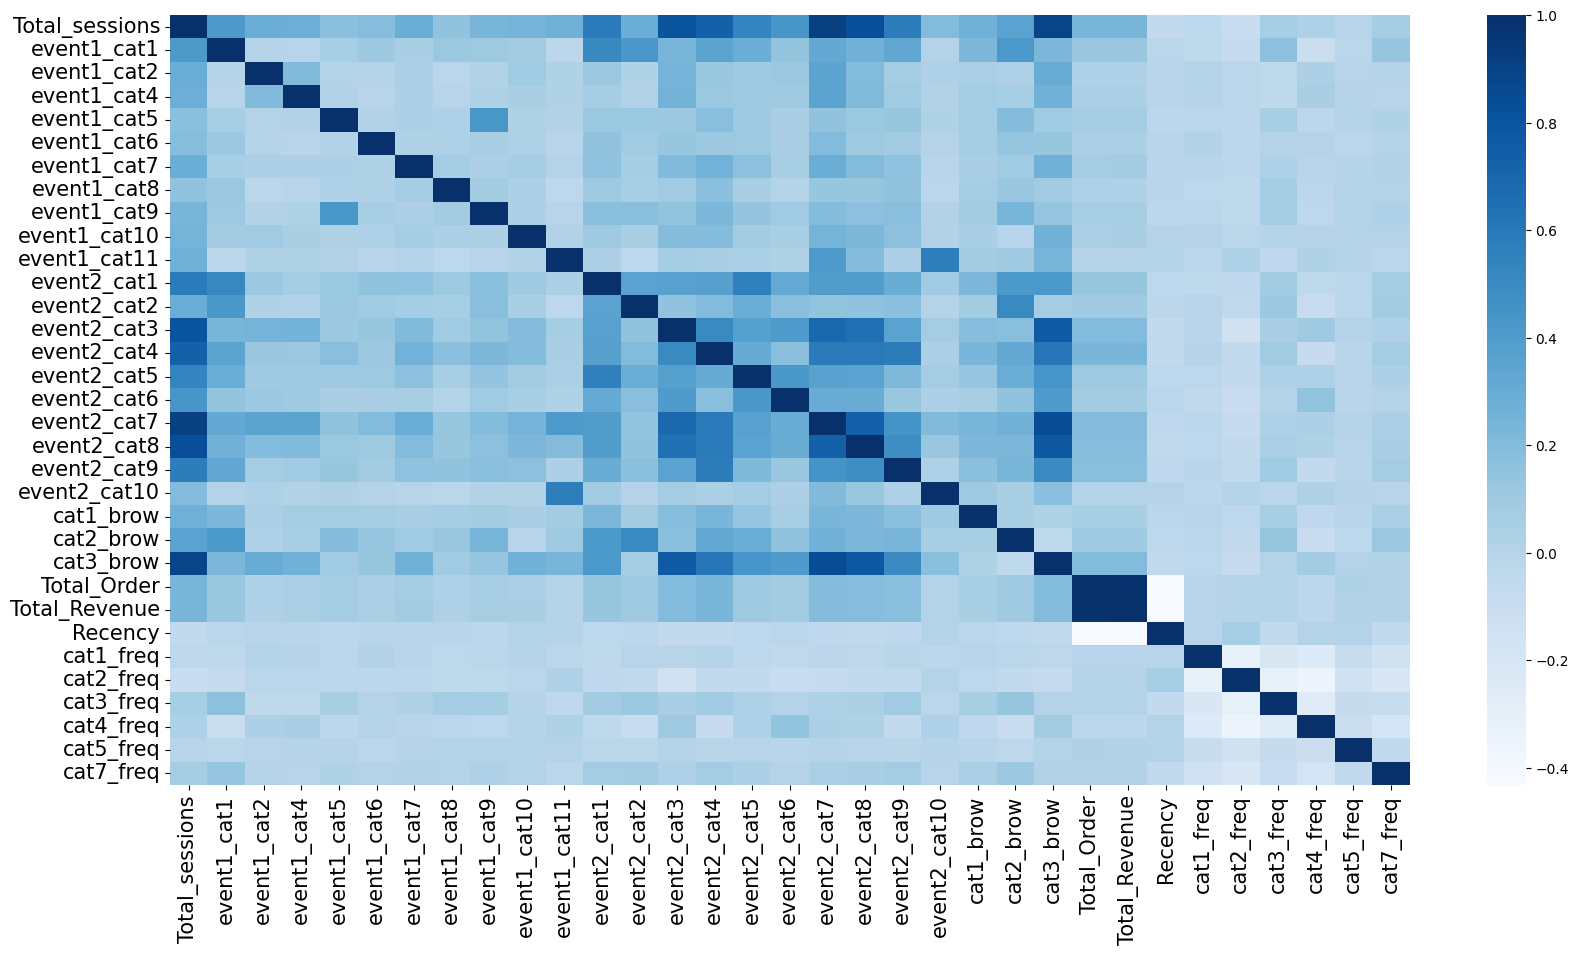

In [37]:
corr = train_x.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap="Blues",
           fmt='d')
plt.tick_params(labelsize = 15)
plt.show()

Since total sessions is highly correlated with several variables (cat3_brow, event2_cat9, evnet2_cat8, event2_cat5, event2_cat4, event2_cat3). I will drop the total sessions from my features.  The results features are time-related, purchased-related, product-related. The final features as following:

#### Features Description:
Non-Transactional Data:
- How the customer interacts with your website (online event1 and event2). Which channel attracts more customers?
 - Number of sessions for each category in event1 and event2
   - event1_cat1
   - event1_cat2
   - event1_cat4
   - event1_cat5
   - event1_cat6
   - event1_cat7
   - event1_cat8
   - event1_cat9
   - event1_cat10
   - event1_cat11
   - event2_cat1
   - event2_cat2
   - event2_cat3
   - event2_cat4
   - event2_cat5
   - event2_cat6
   - event2_cat7
   - event2_cat8
   - event2_cat9
   - event2_cat10

Transactional Data:
- Total order number  
   - Total_Order : Total number of orders of each customer in the training phase.
- Order Regency
   - Recency : Number of days since last purchased
- Order Frequncy  : order frequency of each category in procast1 per customer in the training phase
   - cat1_freq
   - cat2_freq
   - cat3_freq
   - cat4_freq
   - cat5_freq
   - cat7_freq
- Order Revenue
   - Total_Revenue : total revenue of each customer in the training phase.

# 4.	Model Generation  

- Model Performance
  - Use Grid Serach Method to find the best parameters
  - Evalute Results based on test sets using AUC
  
- Overfitting Problem : Using ensemble methods
  - Bagging method: Random Forest (Multi-class Classfication)

## 4.1 Grid Search to find the best parameters

In [38]:
# Drop feature
train_x =  train_x.drop(columns =['Total_sessions'])
test_x =  test_x.drop(columns =['Total_sessions'])

In [39]:
print(test_x.iloc[8])

event1_cat1         0.000000
event1_cat2         1.000000
event1_cat4         1.000000
event1_cat5         0.000000
event1_cat6         0.000000
event1_cat7         1.000000
event1_cat8         0.000000
event1_cat9         0.000000
event1_cat10        0.000000
event1_cat11        0.000000
event2_cat1         2.000000
event2_cat2         0.000000
event2_cat3         1.000000
event2_cat4         6.000000
event2_cat5         2.000000
event2_cat6         2.000000
event2_cat7         9.000000
event2_cat8         2.000000
event2_cat9         1.000000
event2_cat10        0.000000
cat1_brow           0.000000
cat2_brow           4.000000
cat3_brow          21.000000
Total_Order        31.000000
Total_Revenue    2176.020000
Recency             4.000000
cat1_freq           0.193548
cat2_freq           0.612903
cat3_freq           0.032258
cat4_freq           0.000000
cat5_freq           0.000000
cat7_freq           0.161290
Name: 8, dtype: float64


In [40]:
test_x.head()

,event1_cat1,event1_cat2,event1_cat4,event1_cat5,event1_cat6,event1_cat7,event1_cat8,event1_cat9,event1_cat10,event1_cat11,...,cat3_brow,Total_Order,Total_Revenue,Recency,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq,cat7_freq
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,23.0,31,2447.56,37,0.225806,0.548387,0.000000,0.129032,0.00,0.096774
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,...,38.0,20,1655.80,8,0.150000,0.000000,0.350000,0.350000,0.05,0.100000
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2,225.31,312,0.000000,1.000000,0.000000,0.000000,0.00,0.000000
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18,1459.82,93,0.333333,0.444444,0.111111,0.000000,0.00,0.111111
4,3.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,...,142.0,2,233.87,110,0.000000,1.000000,0.000000,0.000000,0.00,0.000000


In [41]:
test_x.tail()

,event1_cat1,event1_cat2,event1_cat4,event1_cat5,event1_cat6,event1_cat7,event1_cat8,event1_cat9,event1_cat10,event1_cat11,...,cat3_brow,Total_Order,Total_Revenue,Recency,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq,cat7_freq
13790,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1,38.34,74,0.0,0.0,1.0,0.0,0.0,0.0
13791,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,6.0,1,76.42,110,0.0,1.0,0.0,0.0,0.0,0.0
13792,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1,74.20,107,0.0,1.0,0.0,0.0,0.0,0.0
13793,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,75.0,1,15.01,285,0.0,0.0,0.0,1.0,0.0,0.0
13794,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,8.0,1,49.63,39,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
train_x.head()

,event1_cat1,event1_cat2,event1_cat4,event1_cat5,event1_cat6,event1_cat7,event1_cat8,event1_cat9,event1_cat10,event1_cat11,...,cat3_brow,Total_Order,Total_Revenue,Recency,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq,cat7_freq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,2.0,6,665.35,250,0.000000,0.833333,0.000000,0.166667,0.000000,0.000000
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,19.0,13,1276.04,18,0.076923,0.461538,0.000000,0.230769,0.000000,0.230769
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,42.0,79,6326.35,3,0.088608,0.746835,0.075949,0.025316,0.012658,0.050633
3,0.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,...,34.0,35,2853.23,10,0.085714,0.428571,0.171429,0.257143,0.000000,0.057143
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,2,225.31,131,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
print(test_x.info)

<bound method DataFrame.info of        event1_cat1  event1_cat2  event1_cat4  event1_cat5  event1_cat6  \
0              0.0          0.0          0.0          0.0          1.0   
1              0.0          0.0          0.0          0.0          1.0   
2              0.0          0.0          0.0          0.0          0.0   
3              0.0          0.0          1.0          0.0          0.0   
4              3.0          0.0          2.0          0.0          1.0   
...            ...          ...          ...          ...          ...   
13790          0.0          0.0          1.0          0.0          0.0   
13791          0.0          0.0          0.0          0.0          1.0   
13792          0.0          1.0          0.0          0.0          0.0   
13793          1.0          0.0          0.0          0.0          0.0   
13794          0.0          1.0          1.0          0.0          1.0   

       event1_cat7  event1_cat8  event1_cat9  event1_cat10  event1_cat11  ...  

In [ ]:
rf = RandomForestClassifier()
param_grid = {
    'max_depth': list(range(5, 10)),
    'max_leaf_nodes': list(range(8, 12)),
    'max_features': ['sqrt', 'auto', 'log2'],
    'n_estimators':[100,200]}

rf_cv = GridSearchCV(estimator = rf,
                     param_grid = param_grid)
rf_cv.fit(train_x, train_y)
print(rf_cv.best_params_)

## 4.2 Random Forest Model Fitting

In [ ]:
# Fit the model based on the GridSearch Result
rf = RandomForestClassifier(n_estimators=200, max_depth = 9, max_features = 'sqrt', max_leaf_nodes= 10).fit(train_x,train_y)
y_pred = rf.predict(test_x)

## 4.3 Feature Importance Analysis

In [ ]:
# Check feature importance and display in bar plot.
print('Feature importance of Random Forest Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf.feature_importances_, index = test_x.columns)
feat_importances.nlargest(10).plot(kind='barh', alpha=0.7)
plt.xlim(left =0, right = 0.4)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

From the feature importance analysis, we can infer that the buying probability is depended on the total number of order, total revenue, recency and previous purchasing behavior of each customer.

## 4.4 Prediction Analysis

In [ ]:
results = rf.predict_proba(test_x) # return [n_samples, n_classes ]
df = pd.DataFrame({'custno': test.custno,
                   'procat1_1': list(results[0][:, 1]),
                   'procat1_2': list(results[1][:, 1]),
                   'procat1_3': list(results[2][:, 1]),
                   'procat1_4': list(results[3][:, 1]),
                   'procat1_5': list(results[4][:, 1]),
                   'procat1_7': list(results[5][:, 1])})
df.head()

In [ ]:
df.drop(columns = ['custno']).mean().plot(kind= 'bar')
plt.title("Prediction of Purchasing Probability")
plt.xlabel('Procat1')
plt.ylabel('Prediction of Purchasing Probability')

The prediction results still show that most of the people will unlikely to make any purchase in the following half years. While among all the category, class 2 in procat1 is the most likely purchase category across all the customers.

# 5. Model Evaluation

### Check Previous Buying Probability

In [ ]:
train_y.mean().plot(kind='bar', alpha=0.7)
plt.xlabel('Procat1')
plt.ylabel('Buying Probability')
plt.title('Buying Probability of each category in Procat1')

Since most of people don't buy product dur the session time, so the dataset is highly imblanced. In this condition, the accuracy is not appropriate. I will use AUC score to evluate the model performance, which accounts for both true- positive and false-positive rates.

## 5.1 Confusion Matrix  

In [ ]:
print(classification_report(test_y,y_pred))

## 5.2 AUC & ROC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = test_y.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y.iloc[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.values.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolation fix
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    interp_func = interp1d(fpr[i], tpr[i], kind='linear', bounds_error=False, fill_value="extrapolate")
    mean_tpr += interp_func(all_fpr)

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes-1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))

plt.plot(fpr[5], tpr[5],
         label='ROC curve of class 7 (area = {0:0.2f})'.format(roc_auc[5]),
         color='black', lw=lw)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20, weight='bold')
plt.ylabel('True Positive Rate', fontsize=20, weight='bold')
plt.title('Extension of Receiver Operating Characteristic to Multi-Class',
          fontsize=20, weight='bold')
plt.legend(loc="lower right", fontsize=15)
plt.tick_params(labelsize=18)
plt.savefig('auc.png')
plt.show()


When auc approach to 1, it means that we have a good model performance.  The micro/macro-average AUC of this model is around 0.60. The highest AUC score for class3 in procast1, which his around 0.71.

# 6. Summary

The customer segmentation analysis indicated that most of the customers are inactive and purchase little. There’s a huge difference between best customers and lost cheap customers in terms of recency, frequency, and revenue.  The company should use different strategies to market each group of customers. <br/>

- High Value: Improve Retention
- Mid Value: Improve Retention + Increase Frequency
- Low Value: Increase Frequency

The purchasing behavior is depended on the total number of order, total revenue, recency and previous purchasing behavior of each customer. The prediction results still show that most of the people will unlikely to make any purchase in the following half years. While among all the category, class 2 in procat1 is the most likely purchase category across all the customers.  Therefore, the marketing team still need to work on improving retention and frequency.


The problem of the Data :

The online data only include 3 class in online browsing category (procat1), while proact1 has a total of 6 classes. The online data is not complete, making the model less robust.


In [ ]:
# saving the model
import pickle
import os

with open("/content/drive/MyDrive/MDS/model.pkl", "wb") as model_file:
  pickle.dump(rf_cv.best_estimator_, model_file)
  print("Model trained and saved successfully.")

In [ ]:
import pickle
import pandas as pd

# Load the saved model
with open("/content/drive/MyDrive/MDS/model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

test_data = pd.DataFrame({
    'event1_cat1': 0.00,
    'event1_cat2': 0.00,
    'event1_cat4': 0.00,
    'event1_cat5': 0.00,
    'event1_cat6': 1.00,
    'event1_cat7': 1.00,
    'event1_cat8': 0.00,
    'event1_cat9': 2.00,
    'event1_cat10': 0.00,
    'event1_cat11': 0.00,
    'event2_cat1': 7.00,
    'event2_cat2': 1.00,
    'event2_cat3': 8.00,
    'event2_cat4': 7.00,
    'event2_cat5': 5.00,
    'event2_cat6': 1.00,
    'event2_cat7': 16.00,
    'event2_cat8': 5.00,
    'event2_cat9': 5.00,
    'event2_cat10': 0.00,
    'cat1_brow': 3.00,
    'cat2_brow': 14.00,
    'cat3_brow': 38.00,
    'Total_Order': 20.00,
    'Total_Revenue': 1655.80,
    'Recency': 8.00,
    'cat1_freq': 0.15,
    'cat2_freq': 0.00,
    'cat3_freq': 0.35,
    'cat4_freq': 0.35,
    'cat5_freq': 0.05,
    'cat7_freq': 0.10
}, index=[0])

# Ensure test data matches model features
expected_features = model.feature_names_in_
test_data = test_data[expected_features]  # Keep only required columns



# Assuming 'results' should contain probabilities, use predict_proba
results = model.predict_proba(test_data)

print(len(results))
cno = 1
# Create DataFrame with probabilities for each class
df = pd.DataFrame({ # Replace with actual custno if available
                   'procat1_1': [p[1] for p in results[0]],  # Access probabilities for class 1
                   'procat1_2': [p[1] for p in results[1]],  # Access probabilities for class 2
                   'procat1_3': [p[1] for p in results[2]],  # Access probabilities for class 3
                   'procat1_4': [p[1] for p in results[3]],  # Access probabilities for class 4
                   'procat1_5': [p[1] for p in results[4]],  # Access probabilities for class 5
                   'procat1_7': [p[1] for p in results[5]]})  # Access probabilities for class 7

df.head()

print(df)
